In [2]:
import pandas as pd
import func

In [3]:
func_ = func.load_recipe(166511)
func_

,recipe_url,recipe_title,recipe_summary1,recipe_summary2,recipe_summary3,recipe_ingredients,recipe_step,recipe_tag,recipe_comment,recipe_view,recipe_category_type,recipe_category_method,recipe_category_situation,row_cnt
0,http://www.10000recipe.com/recipe/6853904,호박 새우젓찌개 만드는 방법~★,3인분,30분 이내,초급,"{'재료': ['둥근호박1개', '청양고추3개', '당근약간', '실파약간', '새...","['#1 먼저 둥근호박 하나를 반달썰기로 썰어 냄비에 넣고', '#2 새우젓 1/2...","['새우젓호박찌개', '새우젓호박째개만드는방법', '새우젓찌개', '호박찌개', '...",1.0,6517.0,찌개,끓이기,일상,1
1,http://www.10000recipe.com/recipe/6853845,바글바글 전복 된장찌개,4인분,30분 이내,아무나,"{'재료': ['된장1스푼', '전복'], '부재료와 양념': ['양파1/2개', ...","['#1 된장 한 큰 술 넣어주었어요.', '#2 전복 듬뿍, 양파 1/2개, 둥근...","['된짱찌개', '된짱찌개맛있게끓이는법', '된장찌개레시피', '된장찌개끓이는법',...",0.0,7019.0,찌개,끓이기,일상,2
2,http://www.10000recipe.com/recipe/6853803,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,None,None,None,"{'재료': ['순두부(연두부)', '바지락30g', '미더덕30g', '멸치육수(...",[],"['순두부찌개', '순두부', '미더덕', '바지락', '달걀', '고추기름', '...",0.0,3054.0,찌개,끓이기,일상,3
3,http://www.10000recipe.com/recipe/6849181,정통 바지락 순두부 찌개,2인분,60분 이내,중급,"{'주재료': ['순두부1봉', '바지락100g', '양파50g', '애호박10g'...","['#1 뚝배기에 양파,다진 마늘,바지락을 넣어 중불에서 살짝 볶는다.', '#2 ...",[],0.0,4217.0,찌개,끓이기,일상,4
4,http://www.10000recipe.com/recipe/6848906,크림토마토 비프 스튜,2인분,60분 이내,중급,"{'주재료': ['쇠고기등심250g', '파프리카1개', '양파1/3개', '마늘2...","['#1 쇠고기는 2cm 크기로 네모나게 썰어 소금과 후추로 밑간한다.', '#2 ...",[],0.0,2053.0,찌개,끓이기,일상,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166506,http://www.10000recipe.com/recipe/6883205,진리의 땅콩버터+바나나 조합! 살짝 구워 노릇노릇~바나나토스트,2인분,10분 이내,아무나,"{'필수 재료': ['바나나1개', '식빵2장', '땅콩버터3숟가락']}","['#1 바나나는 길게 반으로 자르고, 또 반으로 자른다.식빵 한쪽면에 땅콩버터를 ...","['음식요리', '레시피', '바나나', '토스트', '간식', '땅콩버터', '베...",2.0,15000.0,빵,굽기,일상,166507
166507,http://www.10000recipe.com/recipe/6935520,간단한 머쉬마루버섯 매운탕,4인분,20분 이내,초급,"{'재료': ['광어서더리탕1팩', '머쉬마루버섯150g', '양파1/2개', '무...","['#1 매운탕재료 씻어서 준비해주세요', '#2 머쉬마루버섯,양파,대파,무 썰어서...","['머쉬마루버섯', '머쉬마루버섯매운탕', '머쉬마루버섯요리', '간편한', '홈플...",0.0,641.0,국/탕,끓이기,일상,166508
166508,http://www.10000recipe.com/recipe/6963588,우도주막 독일식 굴라쉬 도전♡,None,None,None,"{'재료': ['한우소고기사태250g', '올리브유15ml', '파프리카2개', '...",[],"['유태오굴라쉬', '우도주막굴라쉬', '우도주막유태오굴라쉬', '굴라쉬', '토마...",0.0,699.0,스프,끓이기,일상,166509
166509,http://www.10000recipe.com/recipe/6963587,우도주막 단호박 & 당근 스프 도전♡ (유태오),None,None,None,"{'재료': ['단호박1/2개', '제주당근1개', '양파1/2개', '버터10g'...",[],"['우도주막단호박당근스프', '스프', '단호박당근스프', '우도주막레시피', '우...",0.0,269.0,스프,끓이기,일상,166510


In [4]:
func_pre = func.recipe_preprocessing(func_)
func_pre

,recipe_title,recipe_ingredients
0,호박 새우젓찌개 만드는 방법~★,"{'재료': ['둥근호박1개', '청양고추3개', '당근약간', '실파약간', '새..."
1,바글바글 전복 된장찌개,"{'재료': ['된장1스푼', '전복'], '부재료와 양념': ['양파1/2개', ..."
2,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,"{'재료': ['순두부(연두부)', '바지락30g', '미더덕30g', '멸치육수(..."
3,정통 바지락 순두부 찌개,"{'주재료': ['순두부1봉', '바지락100g', '양파50g', '애호박10g'..."
4,크림토마토 비프 스튜,"{'주재료': ['쇠고기등심250g', '파프리카1개', '양파1/3개', '마늘2..."
...,...,...
166506,진리의 땅콩버터+바나나 조합! 살짝 구워 노릇노릇~바나나토스트,"{'필수 재료': ['바나나1개', '식빵2장', '땅콩버터3숟가락']}"
166507,간단한 머쉬마루버섯 매운탕,"{'재료': ['광어서더리탕1팩', '머쉬마루버섯150g', '양파1/2개', '무..."
166508,우도주막 독일식 굴라쉬 도전♡,"{'재료': ['한우소고기사태250g', '올리브유15ml', '파프리카2개', '..."
166509,우도주막 단호박 & 당근 스프 도전♡ (유태오),"{'재료': ['단호박1/2개', '제주당근1개', '양파1/2개', '버터10g'..."


In [5]:
func_pre_split = func.split_ingredient(func_pre) #돌아가는 시간이 7분 > 2분30초 정도로 절반 이상 절감
#PerformanceWarning이 날 때도 있고 안 날 때도 있고..

C:\Users\glori\OneDrive\문서\GitHub\recipe\models\func.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'ingredient{i}'] = None
C:\Users\glori\OneDrive\문서\GitHub\recipe\models\func.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'quantity{i}'] = None
C:\Users\glori\OneDrive\문서\GitHub\recipe\models\func.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [6]:
func_pre_split #156989*224여야

,recipe_title,recipe_ingredients,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
0,호박 새우젓찌개 만드는 방법~★,"{'재료': ['둥근호박1개', '청양고추3개', '당근약간', '실파약간', '새...",둥근호박,1,개,청양고추,3,개,당근약간,,...,None,None,None,None,None,None,None,None,None,None
1,바글바글 전복 된장찌개,"{'재료': ['된장1스푼', '전복'], '부재료와 양념': ['양파1/2개', ...",된장,1,스푼,전복,,None,양파,1/2,...,None,None,None,None,None,None,None,None,None,None
2,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,"{'재료': ['순두부(연두부)', '바지락30g', '미더덕30g', '멸치육수(...",순두부(연두부),,None,바지락,30,g,미더덕,30,...,None,None,None,None,None,None,None,None,None,None
3,정통 바지락 순두부 찌개,"{'주재료': ['순두부1봉', '바지락100g', '양파50g', '애호박10g'...",순두부,1,봉,바지락,100,g,양파,50,...,None,None,None,None,None,None,None,None,None,None
4,크림토마토 비프 스튜,"{'주재료': ['쇠고기등심250g', '파프리카1개', '양파1/3개', '마늘2...",쇠고기등심,250,g,파프리카,1,개,양파,1/3,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166506,진리의 땅콩버터+바나나 조합! 살짝 구워 노릇노릇~바나나토스트,"{'필수 재료': ['바나나1개', '식빵2장', '땅콩버터3숟가락']}",바나나,1,개,식빵,2,장,땅콩버터,3,...,None,None,None,None,None,None,None,None,None,None
166507,간단한 머쉬마루버섯 매운탕,"{'재료': ['광어서더리탕1팩', '머쉬마루버섯150g', '양파1/2개', '무...",광어서더리탕,1,팩,머쉬마루버섯,150,g,양파,1/2,...,None,None,None,None,None,None,None,None,None,None
166508,우도주막 독일식 굴라쉬 도전♡,"{'재료': ['한우소고기사태250g', '올리브유15ml', '파프리카2개', '...",한우소고기사태,250,g,올리브유,15,ml,파프리카,2,...,None,None,None,None,None,None,None,None,None,None
166509,우도주막 단호박 & 당근 스프 도전♡ (유태오),"{'재료': ['단호박1/2개', '제주당근1개', '양파1/2개', '버터10g'...",단호박,1/2,개,제주당근,1,개,양파,1/2,...,None,None,None,None,None,None,None,None,None,None


In [7]:
func_pre_split.drop(['recipe_ingredients'], axis=1, inplace=True)
func_pre_split

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
0,호박 새우젓찌개 만드는 방법~★,둥근호박,1,개,청양고추,3,개,당근약간,,None,...,None,None,None,None,None,None,None,None,None,None
1,바글바글 전복 된장찌개,된장,1,스푼,전복,,None,양파,1/2,개,...,None,None,None,None,None,None,None,None,None,None
2,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,순두부(연두부),,None,바지락,30,g,미더덕,30,g,...,None,None,None,None,None,None,None,None,None,None
3,정통 바지락 순두부 찌개,순두부,1,봉,바지락,100,g,양파,50,g,...,None,None,None,None,None,None,None,None,None,None
4,크림토마토 비프 스튜,쇠고기등심,250,g,파프리카,1,개,양파,1/3,개,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166506,진리의 땅콩버터+바나나 조합! 살짝 구워 노릇노릇~바나나토스트,바나나,1,개,식빵,2,장,땅콩버터,3,숟가락,...,None,None,None,None,None,None,None,None,None,None
166507,간단한 머쉬마루버섯 매운탕,광어서더리탕,1,팩,머쉬마루버섯,150,g,양파,1/2,개,...,None,None,None,None,None,None,None,None,None,None
166508,우도주막 독일식 굴라쉬 도전♡,한우소고기사태,250,g,올리브유,15,ml,파프리카,2,개,...,None,None,None,None,None,None,None,None,None,None
166509,우도주막 단호박 & 당근 스프 도전♡ (유태오),단호박,1/2,개,제주당근,1,개,양파,1/2,개,...,None,None,None,None,None,None,None,None,None,None


In [8]:
# 기존 DataFrame에서 원하는 column 이름들을 선택
selected_columns = ['ingredient{}'.format(i) for i in range(1, 75)]

# 선택한 column들로 새로운 DataFrame 생성
func_ingre_df = func_pre_split[selected_columns].copy()
func_ingre_df

,ingredient1,ingredient2,ingredient3,ingredient4,ingredient5,ingredient6,ingredient7,ingredient8,ingredient9,ingredient10,...,ingredient65,ingredient66,ingredient67,ingredient68,ingredient69,ingredient70,ingredient71,ingredient72,ingredient73,ingredient74
0,둥근호박,청양고추,당근약간,실파약간,새우젓,물,연두,소금조금,None,None,...,None,None,None,None,None,None,None,None,None,None
1,된장,전복,양파,둥근호박,감자,멸치or멸치간것,다진마늘,대파,두부작은것,청량고추,...,None,None,None,None,None,None,None,None,None,None
2,순두부(연두부),바지락,미더덕,멸치육수(만능육수),고추기름,양파,애호박,파,달걀,마늘,...,None,None,None,None,None,None,None,None,None,None
3,순두부,바지락,양파,애호박,굵은고춧가루,다진마늘,대파,청양고추,홍고추,달걀,...,None,None,None,None,None,None,None,None,None,None
4,쇠고기등심,파프리카,양파,마늘,새송이버섯,방울토마토,치킨스톡,크림파스타소스,올리브유적당량,소금적당량,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166506,바나나,식빵,땅콩버터,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
166507,광어서더리탕,머쉬마루버섯,양파,무약간,대파,깻잎약간,양념소스,고추장,고추가루,쌈장,...,None,None,None,None,None,None,None,None,None,None
166508,한우소고기사태,올리브유,파프리카,양파,다진마늘,애호박,당근,감자,레드와인,데친완숙토마토,...,None,None,None,None,None,None,None,None,None,None
166509,단호박,제주당근,양파,버터,볶은천일염,우유,생크림,파슬리,코코넛슈가,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
#func_ingre_df.loc[func_ingre_df.map(lambda x: '약간' in str(x)).any(axis=1), 'ingredient1']
func_ingre = pd.DataFrame()
for i in range(1,75):
    filtered_rows = func_pre_split[func_pre_split[f'ingredient{i}'].apply(lambda x: '약간' in str(x))]
    func_ingre = pd.concat([func_ingre, filtered_rows])
#filtered_rows = func_ingre_df[func_ingre_df['ingredient1'].apply(lambda x: '약간' in str(x))]
func_ingre

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
1913,늘 사랑받는 뚝배기 계란찜 만드는법,소금약간,,None,달걀,3,개,파,,None,...,None,None,None,None,None,None,None,None,None,None
2977,아삭 아삭 오이볶음,참깨약간,,None,오이,2,개,굵은소금,2,큰술,...,None,None,None,None,None,None,None,None,None,None
4805,동죽 & 바지락칼국수 만들기 ~ 직접 잡아 만들어 더 애착이 가는 요리 ^^,동죽과기타조개약간,,None,바지락,1,봉지,칼국수면,2~3,인분,...,None,None,None,None,None,None,None,None,None,None
5479,트리샐러드 (연말홈파티음식),어린잎채소약간,,None,새싹약간,,None,바나나,1,개,...,None,None,None,None,None,None,None,None,None,None
5907,황태해장국 황금레시피,황태채약간,,None,대파,,None,무,,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165368,시아주버님의 칠순 생신 상차림,고사리,100,g,호박고지,100,g,곤드레나물,100,g,...,None,None,None,None,None,None,None,None,None,None
22817,생애 최고의 날! 온가족이 축하해 준 남편의 생일,맛살,6,개,계란,2,개,밀가루,2,숟가락,...,None,None,None,None,None,None,None,None,None,None
165368,시아주버님의 칠순 생신 상차림,고사리,100,g,호박고지,100,g,곤드레나물,100,g,...,None,None,None,None,None,None,None,None,None,None
44114,"알토란, 6억 대가의 손맛 보름나물 비법",식용유,5,숟가락,들기름,3,숟가락,마늘,3,숟가락,...,g,양파,1,개,대파,1/2,대,깨소금약간,,None


In [10]:
func_ing = func_ingre[:100]
func_ing

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
1913,늘 사랑받는 뚝배기 계란찜 만드는법,소금약간,,None,달걀,3,개,파,,None,...,None,None,None,None,None,None,None,None,None,None
2977,아삭 아삭 오이볶음,참깨약간,,None,오이,2,개,굵은소금,2,큰술,...,None,None,None,None,None,None,None,None,None,None
4805,동죽 & 바지락칼국수 만들기 ~ 직접 잡아 만들어 더 애착이 가는 요리 ^^,동죽과기타조개약간,,None,바지락,1,봉지,칼국수면,2~3,인분,...,None,None,None,None,None,None,None,None,None,None
5479,트리샐러드 (연말홈파티음식),어린잎채소약간,,None,새싹약간,,None,바나나,1,개,...,None,None,None,None,None,None,None,None,None,None
5907,황태해장국 황금레시피,황태채약간,,None,대파,,None,무,,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76994,볶은돼지고기 된장찌개,돼지고기약간,,None,두부,1,모,표고버섯,4,개,...,None,None,None,None,None,None,None,None,None,None
78764,크리스마스 꽃리스 샐러드(콥샐러드),블루베리약간,,None,계란,3,개,파프리카주황약간,,None,...,None,None,None,None,None,None,None,None,None,None
80506,부추계란말이 만만한반찬,부추약간,,None,달걀,3,개,소금,2,꼬집,...,None,None,None,None,None,None,None,None,None,None
83154,비가 오는 날에는 당연히~ 해물전!,식용유약간,,None,부침가루,1,컵,멸치육수(or물),1,컵,...,None,None,None,None,None,None,None,None,None,None


In [11]:
# '약간'이 있는 경우 해당 값을 따로 떼어서 '약간' 열에 추가
#df['약간'] = df.apply(lambda row: [x.replace('약간', '') for x in row if '약간' in x], axis=1)

# '약간'이 있는 경우 해당 열의 값을 수정하여 추가
for i in range(1, 75):
    col_name = f'ingredient{i}'
    unit_col_name = f'unit{i}'

    #func_ingre[unit_col_name] = func_ingre.apply(
    #    lambda row: row[col_name].replace('약간', '') if '약간' in row[col_name] else row[col_name],
    #    axis=1)
    
    func_ing[unit_col_name] = func_ing.apply(
        lambda row: '약간' if pd.notna(row[col_name]) and '약간' in str(row[col_name]) else func_ing[unit_col_name],
        axis=1
    )
    func_ing[col_name] = func_ing.apply(
        lambda row: row[col_name].replace('약간', '') if '약간' in row[col_name] else row[col_name],
        axis=1)
func_ing

C:\Users\glori\AppData\Local\Temp\ipykernel_12104\3966280230.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  func_ing[unit_col_name] = func_ing.apply(
C:\Users\glori\AppData\Local\Temp\ipykernel_12104\3966280230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  func_ing[col_name] = func_ing.apply(


ValueError: Columns must be same length as key

In [23]:
import numpy as np
import pandas as pd

# 예시 데이터 생성
data = np.random.rand(100000, 75)
func_ing = pd.DataFrame(data, columns=[f'ingredient{i}' for i in range(1, 76)])

# 나눌 크기 설정
batch_size = 1000

# 데이터를 작은 배치로 나누기
batches = [func_ing.iloc[i:i+batch_size] for i in range(0, len(func_ing), batch_size)]

# 각 배치를 처리하고 결과를 합치기
for i, batch in enumerate(batches):
    for j in range(1, 76):
        col_name = f'ingredient{j}'
        unit_col_name = f'unit{j}'

        # 각 배치에 대한 처리 수행
        processed_batch = batch.apply(
            lambda row: pd.Series({
                col_name: row[col_name].replace('약간', '') if pd.notna(row[col_name]) and '약간' in str(row[col_name]) else row[col_name],
                unit_col_name: '약간' if pd.notna(row[col_name]) and '약간' in str(row[col_name]) else None
            }),
            axis=1
        )

        # 처리한 결과를 기존 DataFrame에 업데이트
        func_ing.loc[batch.index, [col_name, unit_col_name]] = processed_batch.values

# 필요한 열만 남기기
func_ing = func_ing[[f'ingredient{i}' for i in range(1, 76)] + [f'unit{i}' for i in range(1, 76)]]

# 결과 확인
print(func_ing)

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

# 예시 데이터 생성
data = np.random.rand(100000, 75)
func_ing = pd.DataFrame(data, columns=[f'ingredient{i}' for i in range(1, 76)])

# 나눌 크기 설정
batch_size = 1000

# 데이터를 작은 배치로 나누기
batches = [func_ing.iloc[i:i+batch_size] for i in range(0, len(func_ing), batch_size)]

# 각 배치를 처리하고 결과를 합치기
for j in range(1, 76):
    col_name = f'ingredient{j}'
    unit_col_name = f'unit{j}'

    # 각 배치에 대한 처리 수행
    for i, batch in enumerate(batches):
        func_ing.loc[batch.index, [col_name, unit_col_name]] = batch[col_name].apply(
            lambda val: pd.Series({
                col_name: val.replace('약간', '') if pd.notna(val) and '약간' in str(val) else val,
                unit_col_name: '약간' if pd.notna(val) and '약간' in str(val) else None
            })
        ).values

# 필요한 열만 남기기
func_ing = func_ing[[f'ingredient{i}' for i in range(1, 76)] + [f'unit{i}' for i in range(1, 76)]]

# 결과 확인
func_ing

In [10]:
import numpy as np
import pandas as pd

# 예시 데이터 생성
data = np.random.rand(100000, 75)
func_ing = pd.DataFrame(data, columns=[f'ingredient{i}' for i in range(1, 76)])

# 각 열에 대한 처리 수행
for j in range(1, 76):
    col_name = f'ingredient{j}'
    unit_col_name = f'unit{j}'

    func_ing[[col_name, unit_col_name]] = func_ing[col_name].apply(
        lambda val: pd.Series({
            col_name: val.replace('약간', '') if pd.notna(val) and '약간' in str(val) else val,
            unit_col_name: '약간' if pd.notna(val) and '약간' in str(val) else None
        })
    )

# 필요한 열만 남기기
func_ing = func_ing[[f'ingredient{i}' for i in range(1, 76)] + [f'unit{i}' for i in range(1, 76)]]

# 결과 확인
func_ing

KeyboardInterrupt: 

In [12]:
import numpy as np
import pandas as pd

def process_col_name(dataframe, col_name):
    dataframe[col_name] = dataframe[col_name].apply(
        lambda val: val.replace('약간', '') if pd.notna(val) and '약간' in str(val) else val
    )

def process_unit_col_name(dataframe, col_name, unit_col_name):
    dataframe[unit_col_name] = dataframe[col_name].apply(
        lambda val: '약간' if pd.notna(val) and '약간' in str(val) else dataframe[unit_col_name]
    )

def process_dataframe(dataframe):
    for j in range(1, 76):
        col_name = f'ingredient{j}'
        unit_col_name = f'unit{j}'

        process_col_name(dataframe, col_name)
        process_unit_col_name(dataframe, col_name, unit_col_name)

    # 필요한 열만 남기기
    result_dataframe = dataframe[[f'ingredient{i}' for i in range(1, 76)] + [f'unit{i}' for i in range(1, 76)]]

    return result_dataframe

processed_dataframe = process_dataframe(func_ing)
processed_dataframe

MemoryError: Unable to allocate 781. KiB for an array with shape (100000,) and data type object

In [28]:
for i in range(1, 75):
    col_name = f'ingredient{i}'
    unit_col_name = f'unit{i}'
    func_ingre[unit_col_name] = func_ingre.apply(
        lambda row: '약간' if pd.notna(row[col_name]) and '약간' in str(row[col_name]) else func_ingre[unit_col_name],
        axis=1
    )

    func_ingre[f'ingredient{i}'].replace(to_replace='약간', value='', regex=True, inplace=True)
func_ingre

MemoryError: Unable to allocate 51.4 GiB for an array with shape (83030, 83030) and data type object

In [27]:
for i in range(1, 75):
    col_name = f'ingredient{i}'
    unit_col_name = f'unit{i}'
    func_ingre[unit_col_name] = func_ingre.apply(
        lambda row: '약간' if pd.notna(row[col_name]) and '약간' in str(row[col_name]) else row[col_name],
        axis=1
    )
    
    func_ingre[f'ingredient{i}'].replace(to_replace='약간', value='', regex=True, inplace=True)
func_ingre

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
1913,늘 사랑받는 뚝배기 계란찜 만드는법,소금,,약간,달걀,3,달걀,파,,파,...,None,None,None,None,None,None,None,None,None,None
2977,아삭 아삭 오이볶음,참깨,,약간,오이,2,오이,굵은소금,2,굵은소금,...,None,None,None,None,None,None,None,None,None,None
4805,동죽 & 바지락칼국수 만들기 ~ 직접 잡아 만들어 더 애착이 가는 요리 ^^,동죽과기타조개,,약간,바지락,1,바지락,칼국수면,2~3,칼국수면,...,None,None,None,None,None,None,None,None,None,None
5479,트리샐러드 (연말홈파티음식),어린잎채소,,약간,새싹,,약간,바나나,1,바나나,...,None,None,None,None,None,None,None,None,None,None
5907,황태해장국 황금레시피,황태채,,약간,대파,,대파,무,,무,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165368,시아주버님의 칠순 생신 상차림,고사리,100,고사리,호박고지,100,호박고지,곤드레나물,100,곤드레나물,...,약간,None,None,None,None,None,None,None,None,None
22817,생애 최고의 날! 온가족이 축하해 준 남편의 생일,맛살,6,맛살,계란,2,계란,밀가루,2,밀가루,...,약간,None,None,None,None,None,None,None,None,None
165368,시아주버님의 칠순 생신 상차림,고사리,100,고사리,호박고지,100,호박고지,곤드레나물,100,곤드레나물,...,약간,None,None,None,None,None,None,None,None,None
44114,"알토란, 6억 대가의 손맛 보름나물 비법",식용유,5,식용유,들기름,3,들기름,마늘,3,마늘,...,시판오리불고기,양파,1,양파,대파,1/2,대파,깨소금,,약간


In [22]:
#func_ingre_df.loc[func_ingre_df.map(lambda x: '약간' in str(x)).any(axis=1), 'ingredient1']
func_rhkf = pd.DataFrame()
for i in range(1,75):
    filtered_rows = func_pre_split[func_pre_split[f'ingredient{i}'].apply(lambda x: '(' in str(x))]
    func_rhkf = pd.concat([func_rhkf, filtered_rows])
#filtered_rows = func_ingre_df[func_ingre_df['ingredient1'].apply(lambda x: '약간' in str(x))]
func_rhkf

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
2,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,순두부(연두부),,None,바지락,30,g,미더덕,30,g,...,None,None,None,None,None,None,None,None,None,None
5,감자찌개,돼지고기(찌개용),100,g,감자,1,개,대파,1/2,대,...,None,None,None,None,None,None,None,None,None,None
9,제육볶음 맛있게 만드는 법,돼지고기(뒷다리살),1,근,양파,,None,대파,,None,...,None,None,None,None,None,None,None,None,None,None
39,소고기 야채 볶음,소고기(불고기용),100,g,양파,1/2,개,당근,1/3,개,...,None,None,None,None,None,None,None,None,None,None
67,유자 돼지불고기,돼지고기(불고기),600,g,양파,1/2,개,대파,1,대,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143026,"돈가스만들기, 돈가스소스만들기",돼지고기안심,300,g,습식빵가루,,None,튀김기름,,None,...,None,None,None,None,None,None,None,None,None,None
11133,"밑반찬 3가지(참치 채소조림, 오징어채 꽈리고추 조림, 우엉, 무초장 무침)",참치,150,g,감자,1,개,양파,1/2,개,...,None,None,None,None,None,None,None,None,None,None
54626,부대찌개 / 한우 부대찌개,소고기불고기,100,g,프랑크소시지,2,개,빈스통조림,4,큰술,...,None,None,None,None,None,None,None,None,None,None
67716,매콤한 치롤레쉬림프 루빵 그리고 고소한 크림을 먹은 루빵 [만개의레시피],양파,1/8,개,파프리카,1/4,개,고추,1,g,...,None,None,None,None,None,None,None,None,None,None


In [26]:
# 정규표현식 패턴
pattern = r'\([^)]*\)'

# func_rhkf에서 패턴과 일치하는 부분을 빈 문자열로 대체하여 제거
func_rhkf.replace(to_replace=pattern, value='', regex=True, inplace=True)
func_rhkf

,recipe_title,ingredient1,quantity1,unit1,ingredient2,quantity2,unit2,ingredient3,quantity3,unit3,...,unit71,ingredient72,quantity72,unit72,ingredient73,quantity73,unit73,ingredient74,quantity74,unit74
2,순두부찌개....오도독 씹히는 미더덕이 들어간 순두부찌개!!,순두부,,None,바지락,30,g,미더덕,30,g,...,None,None,None,None,None,None,None,None,None,None
5,감자찌개,돼지고기,100,g,감자,1,개,대파,1/2,대,...,None,None,None,None,None,None,None,None,None,None
9,제육볶음 맛있게 만드는 법,돼지고기,1,근,양파,,None,대파,,None,...,None,None,None,None,None,None,None,None,None,None
39,소고기 야채 볶음,소고기,100,g,양파,1/2,개,당근,1/3,개,...,None,None,None,None,None,None,None,None,None,None
67,유자 돼지불고기,돼지고기,600,g,양파,1/2,개,대파,1,대,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143026,"돈가스만들기, 돈가스소스만들기",돼지고기안심,300,g,습식빵가루,,None,튀김기름,,None,...,None,None,None,None,None,None,None,None,None,None
11133,밑반찬 3가지,참치,150,g,감자,1,개,양파,1/2,개,...,None,None,None,None,None,None,None,None,None,None
54626,부대찌개 / 한우 부대찌개,소고기불고기,100,g,프랑크소시지,2,개,빈스통조림,4,큰술,...,None,None,None,None,None,None,None,None,None,None
67716,매콤한 치롤레쉬림프 루빵 그리고 고소한 크림을 먹은 루빵 [만개의레시피],양파,1/8,개,파프리카,1/4,개,고추,1,g,...,None,None,None,None,None,None,None,None,None,None


In [7]:
ingre = []
for i in range(1, 75):
    func_ingre = func_pre_split[f'ingredient{i}'].to_list()
    ingre.extend(func_ingre)
ingre

['둥근호박',
 '된장',
 '순두부(연두부)',
 '순두부',
 '쇠고기등심',
 '돼지고기(찌개용)',
 '알래스카연어',
 '간돼지고기',
 '두부',
 '돼지고기(뒷다리살)',
 '돼지고기목살',
 '낙지',
 '닭가슴살',
 '낙지',
 '닭안심살',
 '물',
 '돼지고기목살',
 '돼지고기목살',
 '양파',
 '배추우거지',
 '애호박',
 '열무김치',
 '오징어',
 '생물주꾸미',
 '소고기다짐',
 '두부',
 '닭가슴살',
 '돼지고기앞다리',
 '두부',
 '돼지갈비',
 '청국장',
 '된장',
 '닭가슴살',
 '꾸미',
 '훈제오리고기',
 '감자',
 '두부',
 '소고기(불고기용)',
 '삼겹살',
 '청정원멸치국물내기티백',
 '햄',
 '콩나물',
 '조랭이떡',
 '돼지갈비',
 '감자큰거',
 '삼겹살',
 '호박',
 '돼지고기목살',
 '돼지고기',
 '순두부',
 '순두부',
 '청국장',
 '표고버섯',
 '통조림햄',
 '건표고버섯',
 '돼지고기잡채용',
 '당면',
 '동태',
 '감자',
 '된장',
 '고기불고기감',
 '돼지고기',
 '닭안심살',
 '양파',
 '돼지고기(불고기)',
 '돼지고기(불고기)',
 '파김치',
 '호박오가리',
 '소라',
 '돼지고기',
 '소고기(등심)',
 '돼지고기',
 '다시마조금',
 '돼지고기다짐육',
 '콩나물',
 '멸치',
 '소고기',
 '간돼지고기',
 '크래미',
 '두부',
 '돼지고기',
 '당면',
 '쌀뜨물',
 '신김치',
 '목살돼지고기',
 '닭',
 '찐찰옥수수',
 '파김치',
 '돼지고기안심',
 '두부',
 '콩국물',
 '아몬드',
 '양배추',
 '밥',
 '흙애서꿀고구마',
 '고구마',
 '달걀',
 '계란',
 '옥수수',
 '옥수수',
 '단호박',
 '문어',
 '떡볶이떡',
 '부추',
 '삶은소면',
 '백설자연재료부침가루',
 '백설쿠킷오꼬노미야끼KIT',
 '밥',
 '애호박',
 '바나나',
 '깻잎',
 

In [8]:
len(ingre) #156989*74

11617186

In [31]:
from collections import Counter
import pandas as pd

ingre_cnt = Counter(ingre) # type: 'collections.Counter'
ingre_df = pd.DataFrame.from_dict(ingre_cnt, orient='index', columns=['count']).reset_index()
ingre_df

,index,count
0,둥근호박,116
1,된장,7408
2,순두부(연두부),2
3,순두부,879
4,쇠고기등심,27
...,...,...
70362,닭찜물약간씩,1
70363,부추약간진간장,1
70364,건머위대,1
70365,매운마요네즈약간,1


In [13]:
ingre_df.sort_values(by='count', ascending=False)

,index,count
19989,None,10171158
15,양파,47133
327,설탕,47015
799,다진마늘,45365
14,물,35345
...,...,...
30828,대파(엄지손가락굵기만한것),1
30829,아크릴수세미(스폰지),1
30831,송손썬대파,1
30833,(다진)미나리,1


In [32]:
#idx = ingre_df[ingre_df['index'].isnull()].index
ingre_del = ingre_df.copy()
ingre_del = ingre_del.dropna(subset=['index'])
ingre_del

,index,count
0,둥근호박,116
1,된장,7408
2,순두부(연두부),2
3,순두부,879
4,쇠고기등심,27
...,...,...
70362,닭찜물약간씩,1
70363,부추약간진간장,1
70364,건머위대,1
70365,매운마요네즈약간,1


In [41]:
ingre_del[ingre_del['count'] == 1]

,index,count
20,생물주꾸미,1
25,꾸미,1
30,청정원멸치국물내기티백,1
56,목살돼지고기,1
64,흙애서꿀고구마,1
...,...,...
70362,닭찜물약간씩,1
70363,부추약간진간장,1
70364,건머위대,1
70365,매운마요네즈약간,1


In [34]:
ingre_del[ingre_del['index'] == '']

,index,count


In [36]:
ingre_del[ingre_del.isna().any(axis=1)]

,index,count


In [38]:
# 'index' 열에서 '약간'을 포함하는 행 추출
filtered = ingre_df[ingre_df['index'].apply(lambda x: '약간' in str(x))]
filtered

,index,count
753,소금약간,14652
1060,참깨약간,339
1567,동죽과기타조개약간,1
1721,어린잎채소약간,88
1816,황태채약간,4
...,...,...
70357,달래양념장약간,1
70362,닭찜물약간씩,1
70363,부추약간진간장,1
70365,매운마요네즈약간,1


In [39]:
filtered = ingre_df[ingre_df['index'].apply(lambda x: '(' in str(x))]
filtered

,index,count
2,순두부(연두부),2
5,돼지고기(찌개용),38
9,돼지고기(뒷다리살),9
28,소고기(불고기용),51
44,돼지고기(불고기),69
...,...,...
70300,소금(샐러드용),1
70307,견과류(해바라기or호박씨or땅콩),1
70308,육수(밑국물),1
70321,쌀국수면약간(생략가능),1


C:\Users\glori\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 46181 (\N{HANGUL SYLLABLE DUNG}) missing from current font.
  fig.canvas.draw()
C:\Users\glori\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from current font.
  fig.canvas.draw()
C:\Users\glori\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from current font.
  fig.canvas.draw()
C:\Users\glori\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  fig.canvas.draw()
C:\Users\glori\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 49632 (\N{HANGUL SYLLABLE SOE}) missing from current font.
  fig.canvas.draw()
C:\Users\glori\AppData\Local\Programs\P

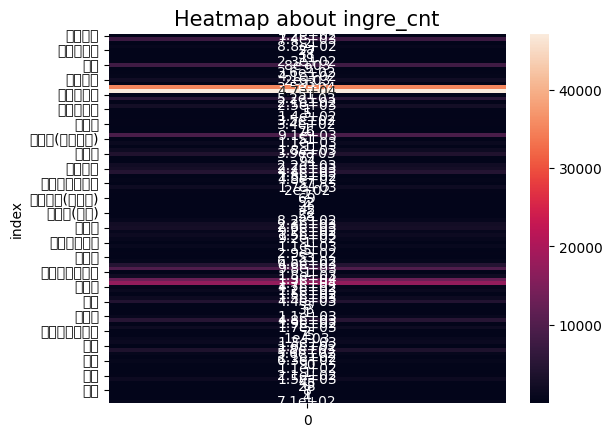

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

#ingre_df['index'] = pd.to_numeric(ingre_df['index'], errors='coerce')
plt.rcParams['font.family'] = 'sans-serif'
sns.heatmap(cut.set_index('index'), annot=True)
plt.title('Heatmap about ingre_cnt', fontsize=15)
plt.show()

In [14]:
quant = []
for i in range(1, 75):
    func_quant = func_pre_split[f'quantity{i}'].to_list()
    quant.extend(func_quant)
quant

['1',
 '1',
 '',
 '1',
 '250',
 '100',
 '1',
 '1',
 '2',
 '1',
 '',
 '1',
 '3',
 '',
 '5-6',
 '500',
 '600',
 '700',
 '1/4',
 '2',
 '1/3',
 '300',
 '2',
 '20',
 '1',
 '340',
 '300',
 '1',
 '1/2',
 '600',
 '1',
 '1+1/2',
 '1',
 '8',
 '300',
 '1',
 '',
 '100',
 '1+1/2',
 '1',
 '',
 '300',
 '350',
 '600',
 '1',
 '500',
 '1/3',
 '',
 '200',
 '',
 '1',
 '1',
 '7',
 '1/2',
 '1/4',
 '150',
 '500',
 '',
 '1',
 '',
 '300',
 '270',
 '3-4',
 '1',
 '600',
 '400',
 '',
 '100',
 '1',
 '150',
 '200',
 '',
 '',
 '150',
 '300',
 '400',
 '400',
 '200',
 '1',
 '1',
 '250',
 '250',
 '2.5',
 '',
 '250',
 '1',
 '2',
 '',
 '300',
 '1',
 '2',
 '2',
 '1',
 '1',
 '1',
 '200',
 '2',
 '8',
 '5',
 '3',
 '1',
 '1',
 '2',
 '1/5',
 '1',
 '100',
 '1',
 '1',
 '1',
 '2',
 '',
 '',
 '2',
 '170',
 '1',
 '1',
 '2/3',
 '1',
 '1',
 '',
 '',
 '1/8',
 '200',
 '3',
 '330',
 '100',
 '50',
 '1/2',
 '2',
 '',
 '250',
 '2',
 '1',
 '3',
 '',
 '1/2',
 '',
 '1',
 '',
 '1',
 '5',
 '3',
 '1/2',
 '1',
 '1',
 '',
 '1',
 '250',
 '2~3',
 '1

In [15]:
len(quant)

11617186

In [16]:
from collections import Counter
import pandas as pd

quant_cnt = Counter(quant) # type: 'collections.Counter'
quant_df = pd.DataFrame.from_dict(quant_cnt, orient='index', columns=['count']).reset_index()
quant_df

,index,count
0,1,395729
1,,311350
2,250,4149
3,100,18852
4,2,175401
...,...,...
1571,1680,1
1572,800-1000,1
1573,19-20,1
1574,14.6,1


In [17]:
quant_df.sort_values(by='count', ascending=False)

,index,count
930,None,10171158
0,1,395729
1,,311350
4,2,175401
15,1/2,115490
...,...,...
960,10-13,1
964,309,1
966,3.45,1
969,1000~1300,1


In [18]:
unit = []
for i in range(1, 75):
    func_unit = func_pre_split[f'unit{i}'].to_list()
    unit.extend(func_unit)
unit

['개',
 '스푼',
 None,
 '봉',
 'g',
 'g',
 '개',
 '컵',
 '모',
 '근',
 None,
 '마리',
 '쪽',
 None,
 '쪽',
 'ml',
 'g',
 'g',
 '개',
 '컵',
 '개',
 'g',
 '마리',
 '마리',
 '쪽',
 'g',
 'g',
 'kg',
 '모',
 'g',
 '덩어리',
 'T',
 'Kg',
 '마리',
 'g',
 '개',
 None,
 'g',
 '근',
 '봉',
 None,
 'g',
 'g',
 'g',
 '개',
 '그램',
 '개',
 None,
 'g',
 None,
 '봉지',
 '팩',
 '개',
 '통',
 '컵',
 'g',
 'g',
 None,
 '개',
 None,
 'g',
 'g',
 '쪽',
 '개',
 'g',
 'g',
 None,
 'g',
 '웅큼',
 'g',
 'g',
 None,
 None,
 'g',
 'g',
 'g',
 'g',
 'g',
 '줄',
 '모',
 'g',
 'g',
 '종이컵',
 None,
 'g',
 '마리',
 '개',
 None,
 'g',
 '모',
 '가지적당량',
 '줌',
 '조각',
 '공기',
 '개',
 'g',
 '개',
 '개',
 '개',
 '개',
 '개',
 '마리',
 '줌',
 '단',
 '줌',
 'g',
 '개',
 '공기',
 '개',
 '개',
 None,
 None,
 '공기',
 'g',
 '공기',
 '컵',
 '모',
 '개',
 '개',
 None,
 None,
 '통',
 'g',
 '공기',
 'g',
 'g',
 'g',
 '종이컵',
 '쪽',
 None,
 'g',
 '컵',
 '개',
 '개',
 None,
 '모',
 None,
 '공기',
 None,
 '줌',
 '개',
 '개',
 '마리',
 '개',
 'kg',
 None,
 '개',
 'g',
 '줌',
 '쪽',
 'g',
 None,
 '개',
 'g',
 None,
 '개',
 '개',
 

In [20]:
len(unit)

11617186

In [21]:
from collections import Counter
import pandas as pd

unit_cnt = Counter(unit) # type: 'collections.Counter'
unit_df = pd.DataFrame.from_dict(unit_cnt, orient='index', columns=['count']).reset_index()
unit_df

,index,count
0,개,219131
1,스푼,51698
2,None,10493392
3,봉,3359
4,g,136339
...,...,...
3863,호박전재료,1
3864,스푼이예요,1
3865,은술,1
3866,머위장아찌,1


In [22]:
unit_df.sort_values(by='count', ascending=False)

,index,count
2,None,10493392
0,개,219131
39,큰술,170002
4,g,136339
13,T,121799
...,...,...
1884,황설탕적당량,1
1885,스푼고춧가루,1
1887,mI,1
1889,소큼,1
